# Deep Learning: 
# Classify Fashion-MNIST with a simple CNN in Keras

Original version from https://medium.com/tensorflow/hello-deep-learning-fashion-mnist-with-keras-50fcff8cd74a, adapted & extended by Xander Steenbrugge.

## Notebook Overview

This is a tutorial of how to classify **fashion_mnist** data with a simple **Convolutional Neural Network** in Keras. 
Keras is now part of the core TensorFlow library, in addition to being an independent open source project. 

We will work our way to an efficiently regularized, convolutional network in small, incremental steps, starting from a simple, linear model and gradually adding more and more complexity to our neural network.


The [fashion_mnist](https://github.com/zalandoresearch/fashion-mnist) data: 
60,000 train and 10,000 test data with 10 categories. Each gray-scale image is 28x28.

<br> **Label**	**Description**
<br> 0 T-shirt/top
<br> 1 Trouser
<br> 2 Pullover
<br> 3 Dress
<br> 4 Coat
<br> 5 Sandal
<br> 6 Shirt
<br> 7 Sneaker
<br> 8 Bag
<br> 9 Ankle boot

Each gray-scale image is 28x28

# Setup
First, install TensorFlow version 1.8.0 and import the Fashion-MNIST dataset
We will also be using numpy, matplotlib and the native Keras package, so install those if you haven't already!

Check the requirements.txt file for all necessary dependencies!

In [0]:
#Test your imports:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


# 1 Data prep

## 1.0 Download the fashion_mnist data
Now, let's download fashion-mnist which is one of the Keras datasets: https://keras.io/datasets/
Pull the dataset from disk into cache memory by storing it in numpy arrays.
As a sanity check, print some shapes to make sure everything is as expected! You should have images of 28 by 28 pixels.

In [5]:
# Load the fashion-mnist pre-shuffled train data and test data
(x_train_data, y_train_data), (x_test_data, y_test_data) = tf.keras.datasets.fashion_mnist.load_data()
# Define the text labels:
dataset_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9
#Print some shapes of the data:
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


## 1.1 Visualize the data
Before we start defining any models, lets have a look at our data to get a sense of what we're dealing with.
Use matplotlib to visualise some of the training images, can you identify the classes yourself?
Perhaps create a simple, callable function that plots a dataset image, given its index.

x_train shape: (60000, 28, 28) y_train shape: (60000,)
60000 train set samples.
10000 test set samples.


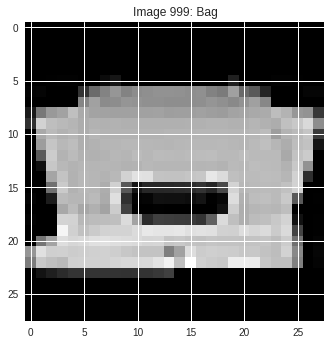

In [6]:
# Print training set shape - note there are 60,000 training data of image size of 28x28, 60,000 train labels)
print("x_train shape:", x_train_data.shape, "y_train shape:", y_train_data.shape)

# Print the number of training and test datasets
print(x_train_data.shape[0], 'train set samples.')
print(x_test_data.shape[0], 'test set samples.')

def plot_image(img_index):
    # y_train contains the lables, ranging from 0 to 9
    label_index = y_train_data[img_index]
    plt.imshow(x_train_data[img_index]/255, cmap = 'gray')
    plt.title("Image %d: %s" %(img_index, dataset_labels[label_index]))
    

# Image index, you can pick any number between 0 and 59,999
img_index = 999
plot_image(img_index)


## 1.2 Data normalization
First investigate the range of the pixel values in the images: what are the min and max you find?

For a neural network to work well, we want these pixel values to be within the range 0-1. Rescale the image pixel values to make this so!

In [7]:
print("Dataset samples have min of %.1f and max of %.1f." %(np.min(x_train_data), np.max(x_train_data)))

x_train_data = x_train_data.astype('float32') / 255
x_test_data = x_test_data.astype('float32') / 255

print("After rescaling, images now have min of %.1f and max of %.1f." %(np.min(x_train_data), np.max(x_train_data)))


Dataset samples have min of 0.0 and max of 255.0.
After rescaling, images now have min of 0.0 and max of 1.0.


## 1.3 Split the data into train/validation/test data sets
In Machine Learning, we always want to be able to validate how well our model is doing on data it hasn't yet trained on.

*   Training data - used for training the model
*   Validation data - used for tuning the hyperparameters and evaluate the models
*   Test data - used to test the model after the model has gone through initial vetting by the validation set.

Split off 10% of the training data and put this into the validation set!

In [8]:
validation_fraction = .1

total_train_samples = len(x_train_data)
validation_samples = int(total_train_samples * validation_fraction)
train_samples = total_train_samples - validation_samples

# Further break training data into train / validation sets
(x_train, y_train) = x_train_data[:train_samples], y_train_data[:train_samples] 
(x_valid, y_valid) = x_train_data[train_samples:], y_train_data[train_samples:]

x_test, y_test = x_test_data, y_test_data
print("We'll use %d train - %d validation - %d test images." %(train_samples, validation_samples, len(x_test)))


We'll use 54000 train - 6000 validation - 10000 test images.


## 1.4 Some final preprocessing
Most image datasets consist of rgb images. Because of this, Keras will expect each image to have 3 dimensions: [x_pixels, y_pixels, color_channels]. Since our images are grayscale, the color dimension is equal to one and implicitly left out in the numpy arrays. Reshape the image data to contain an explicit color channel of dimension 1. (Your final numpy arrays should have the dimension [nr_samples, x_pixels, y_pixels, 1].)

Secondly, it is very common in deep learning to do classification tasks. To train our model, we will use the categorical crossentropy loss (see https://keras.io/losses/). To compute this, we have to format our image labels as one-hot-vectors. The easiest way to do this is with the tf.keras.utils.to_categorical() function, see: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical.

In [9]:
# Reshape input data from (28, 28) to (28, 28, 1)
w, h = 28, 28
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Print training set shape
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Print the number of training, validation, and test datasets
print(x_train.shape, 'train set')
print(x_valid.shape, 'validation set')
print(x_test.shape, 'test set')


x_train shape: (54000, 28, 28, 1) y_train shape: (54000, 10)
(54000, 28, 28, 1) train set
(6000, 28, 28, 1) validation set
(10000, 28, 28, 1) test set


# 2 Creating a model

There are two APIs for defining a model in Keras:
1. [Sequential model API](https://keras.io/models/sequential/)
2. [Functional API](https://keras.io/models/model/)

In this notebook we are using the Sequential model API. 
If you are interested in a tutorial using the Functional API, checkout Sara Robinson's blog [Predicting the price of wine with the Keras Functional API and TensorFlow](https://medium.com/tensorflow/predicting-the-price-of-wine-with-the-keras-functional-api-and-tensorflow-a95d1c2c1b03).

In defining the models today, we will be using some of these Keras APIs: (you can check the documentation with these links:)
*   Dense()    [link text](https://keras.io/layers/core/) - Create a fully connected layer
*   Conv2D()   [link text](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D/) - create a convolutional layer 
*   Pooling()  [link text](https://keras.io/layers/pooling/) - create a pooling layer 
*   Dropout()  [link text](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) - apply drop out 

## 2.0 Baseline: a simple linear model
As a first baseline, we will create a very simple, linear model consisting of one linear transformation matrix and train it with backpropagation.

*  To create the model object, use the tf.keras.Sequential() function as shown here: https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential.
Since we're not using convolutions for now, we can simply flatten all input pixels into a single row per image containing 28x28 pixel values.

*  Then add a single, linear layer that maps all these pixels onto the 10 output classes. Since the outputs represent class probabilities we can use a softmax activation at the output of our model.

*  You can print a description of your model using model.summary()

Extra question: what does the softmax activation actually do? How does this affect our training procedure?
Here is a good post explaining most of the details: https://medium.com/data-science-bootcamp/understand-the-softmax-function-in-minutes-f3a59641e86d

In [10]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Take a look at the model summary
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


## Compile the model
Configure the learning process with compile() API before training the model. It receives three arguments:

*   An optimizer, we'll use adam
*   A loss function, we'll use the 'categorical_crossentropy'
*   A list of metrics, here we'll start with 'accuracy'

See https://keras.io/models/model/ for details.

In [0]:
#Compile the model:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

## Train the model

Now let's train the model with fit() API.

We use  the [ModelCheckpoint](https://keras.io/callbacks/#modelcheckpoint) API to save the model after every epoch. Set "save_best_only = True" to save only when the validation accuracy improves.

You will also have to configure the batch-size and the number of epochs to train for.
What do these words mean exactly?

In [12]:
y_train.shape

(54000, 10)

In [18]:
import keras.callbacks
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)
model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_valid, y_valid), callbacks=[checkpointer])

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
21312/54000 [==========>...................] - ETA: 2s - loss: 0.3991 - acc: 0.8628

KeyboardInterrupt: ignored

## Load Model with the best validation accuracy
Use the .load_weights() function for this!

In [0]:
# Load the weights with the best validation accuracy:
model.load_weights('model.weights.best.hdf5')

## Test Accuracy
Since we used our validation set to choose the best model, we are implicitly already overfitting on this subset of the data. To get the final accuracy estimate our model would get on completely unseen data, compute the accuracy on the test set! Use the .evaluate() function for this.

In [19]:
# Evaluate the model on test set, and print the accuracy you get:
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.8424


## Visualize prediction
Now let's visualize the predictions from the model you just trained. 
First we get the predictions with the model from the test data.
Then we visualize some images from the test data set, and set the titles with the prediction (and the groud truth label).
If the prediction matches the true label, the title will be green; otherwise it's displayed in red.
Package everything in a nice, callable function 'visualize_model_predictions(model, x, y)'

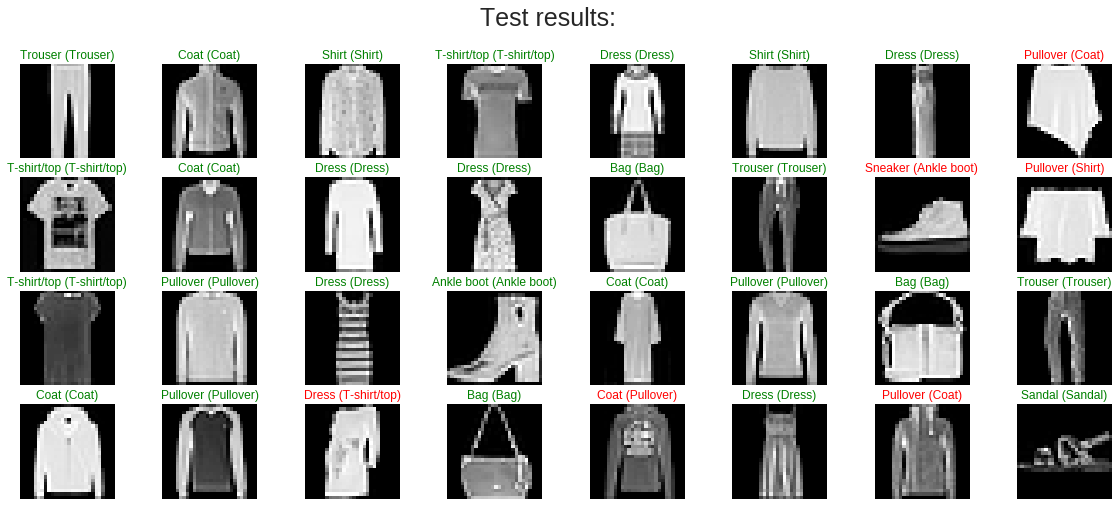

In [17]:
def visualize_model_predictions(model, x_test, y_test, title_string):
    y_hat = model.predict(x_test)

    # Plot a random sample of 10 test images, their predicted labels and ground truth
    figure = plt.figure(figsize=(20, 8))
    for i, index in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
        ax = figure.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
        # Display each image
        ax.imshow(np.squeeze(x_test[index]), cmap = 'gray')
        predict_index = np.argmax(y_hat[index])
        true_index = np.argmax(y_test[index])
        # Set the title for each image
        ax.set_title("{} ({})".format(dataset_labels[predict_index], 
                                      dataset_labels[true_index]),
                                      color=("green" if predict_index == true_index else "red"))
    figure.suptitle("%s results:" %title_string, fontsize=25)
        
visualize_model_predictions(model, x_test, y_test, 'Test')



**Plotting the weights of trained network:**

Visualise what this single, linear layer has learned to detect for each class by plotting the weights of trained network.
Our transformation layer is a weight matrix of dimension [28x28, 10]. In a sense, it has learned a 'filter' for each of the 10 classes. Try to plot what these 10 filters look like, by reshaping them into 28x28 images and visualising the results for each class with matplotlib.imshow().

To get the weight matrix of your trained model, you can use the model.layers and .get_weights() functions.



Found FC Layer!


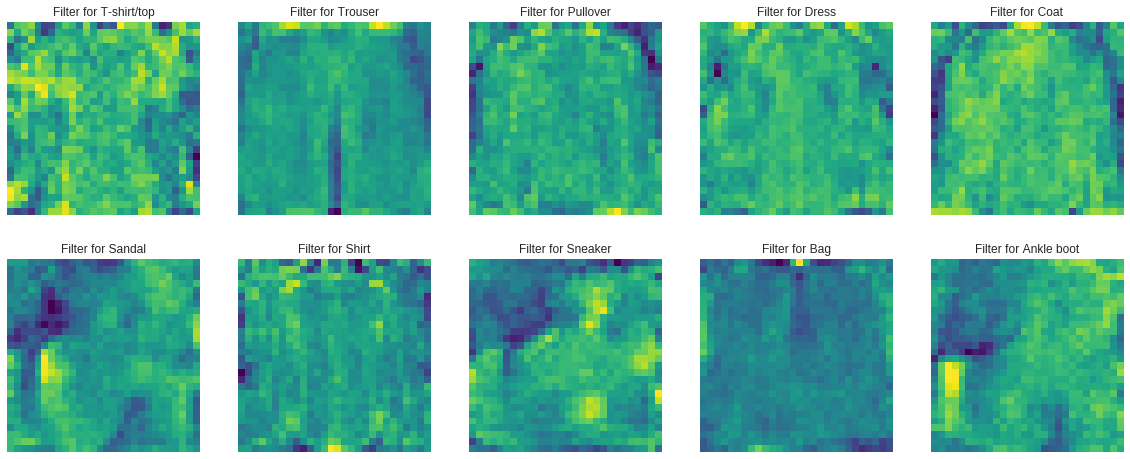

In [21]:
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        print("Found FC Layer!")
        w,b = weights
        filters = np.reshape(w, (28,28,10))
        
def visualize_filters(filters, title_string):
    figure = plt.figure(figsize=(20, 8))
    for i, index in enumerate(np.random.choice(x_test.shape[0], size=10, replace=False)):
        ax = figure.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(filters[:,:,i], cmap = 'viridis')
        ax.set_title("%s for %s" %(title_string, dataset_labels[i]))

visualize_filters(filters, 'Filter')



## Average image for each class
Compare the filters you just plotted with the average image for each class, do you notice any differences? Why?

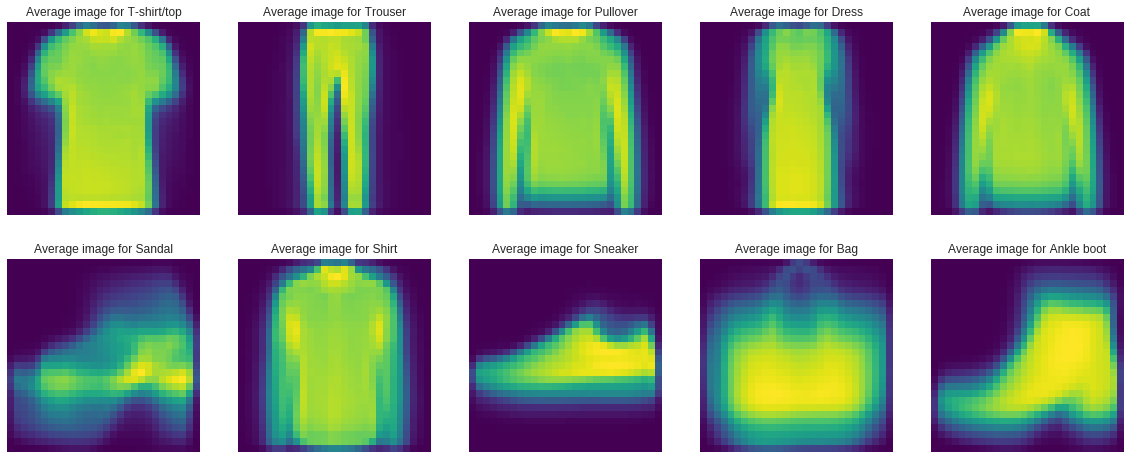

In [22]:
avg_images = np.zeros((28,28,1,10))
class_images = [0]*10

for i in range(len(x_train)):
    img = x_train[i]
    label = np.argmax(y_train[i])
    
    avg_images[:,:,:,label] += img
    class_images[label] += 1

for i in range(10):
    avg_images[:,:,:,i] = avg_images[:,:,:,i]/class_images[i]

avg_images = np.squeeze(avg_images)
visualize_filters(avg_images, 'Average image')


## Extra assignment 3:
Change the code in block 1.0 to work with MNIST instead of Fashion-MNIST (everything else can stay the same). Rerun all the code you've written so far.

What Test-accuracy do you get with a simple, linear model? Can you see now why MNIST is gradually losing favor as a benchmarking dataset? What about the filter visualisations VS the average images, they look interesting right? Try to think about what exactly is going on here...

In [0]:
# dataset_to_use = 'mnist' #'mnist'

# if dataset_to_use == 'fashion-mnist':
#     # Load the fashion-mnist pre-shuffled train data and test data
#     (x_train_data, y_train_data), (x_test_data, y_test_data) = tf.keras.datasets.fashion_mnist.load_data()
#     # Define the text labels:
#     dataset_labels = ["T-shirt/top",  # index 0
#                             "Trouser",      # index 1
#                             "Pullover",     # index 2 
#                             "Dress",        # index 3 
#                             "Coat",         # index 4
#                             "Sandal",       # index 5
#                             "Shirt",        # index 6 
#                             "Sneaker",      # index 7 
#                             "Bag",          # index 8 
#                             "Ankle boot"]   # index 9
# else:
#     (x_train_data, y_train_data), (x_test_data, y_test_data) = tf.keras.datasets.mnist.load_data()
#     # Define the text labels:
#     dataset_labels = ["0",  # index 0
#                             "1",  # index 1
#                             "2",  # index 2 
#                             "3",  # index 3 
#                             "4",  # index 4
#                             "5",  # index 5
#                             "6",  # index 6 
#                             "7",  # index 7 
#                             "8",  # index 8 
#                             "9"]  # index 9

# #Print the shapes of the dataset:
# print("x_train shape:", x_train_data.shape, "y_train shape:", y_train_data.shape)



x_train shape: (60000, 28, 28) y_train shape: (60000,)


# 2.1 Let's turn this into a real neural network!
Add a single hidden layer to the model and add an activation function after that layer (eg 'relu').
The number of hidden units in this layer is usually something in between the input dimension (28x28) and the output dimension (10). Play around with the activation function and the number of hidden units, how do they affect the models performance / training speed?

In [0]:
model = tf.keras.Sequential()

# Flatten --> Dense_Relu --> Dense_Softmax:

# Flatten all the pixels (You must define the input shape in the first layer of the neural network)

model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
# Add one Dense layer mapping all those pixels onto 10 output classes (add a softmax activation):

# Take a look at the model summary:
model.summary()


# Take a look at the model summary:
model.summary()

#Compile the model:


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_35 (Dense)             (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_

In [0]:
## Add a checkpointer and fit the model on the train data: (you have already done this, see above!)

#Compile the model:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
import keras.callbacks
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_valid, y_valid), callbacks=[checkpointer])

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
53888/54000 [============================>.] - ETA: 0s - loss: 0.5590 - acc: 0.8085
Epoch 00001: val_loss improved from inf to 0.43958, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 8s 140us/step - loss: 0.5590 - acc: 0.8085 - val_loss: 0.4396 - val_acc: 0.8475
Epoch 2/10
53632/54000 [============================>.] - ETA: 0s - loss: 0.4197 - acc: 0.8523
Epoch 00002: val_loss improved from 0.43958 to 0.41342, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 6s 108us/step - loss: 0.4194 - acc: 0.8523 - val_loss: 0.4134 - val_acc: 0.8552
Epoch 3/10
53632/54000 [============================>.] - ETA: 0s - loss: 0.3815 - acc: 0.8640
Epoch 00003: val_loss improved from 0.41342 to 0.37498, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 6s 104us/step - loss: 0.3814 - acc: 0.8640 - val_loss: 0.3750 - val_acc: 0.8687
E

In [0]:
# Evaluate the model on test set, and print the accuracy you get:
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.8686


## Evaluation
Load the best model (according to the validation set) and compute the test accuracy. Re-use your 'visuzalize_model_predictions()' function to display some results.

**Extra question:** Why can't we also visualise the filters learned by this neural network with one hidden layer? What's the problem in this case? Notice how this gives rise to the whole "interpretability" problem in Deep Learning.

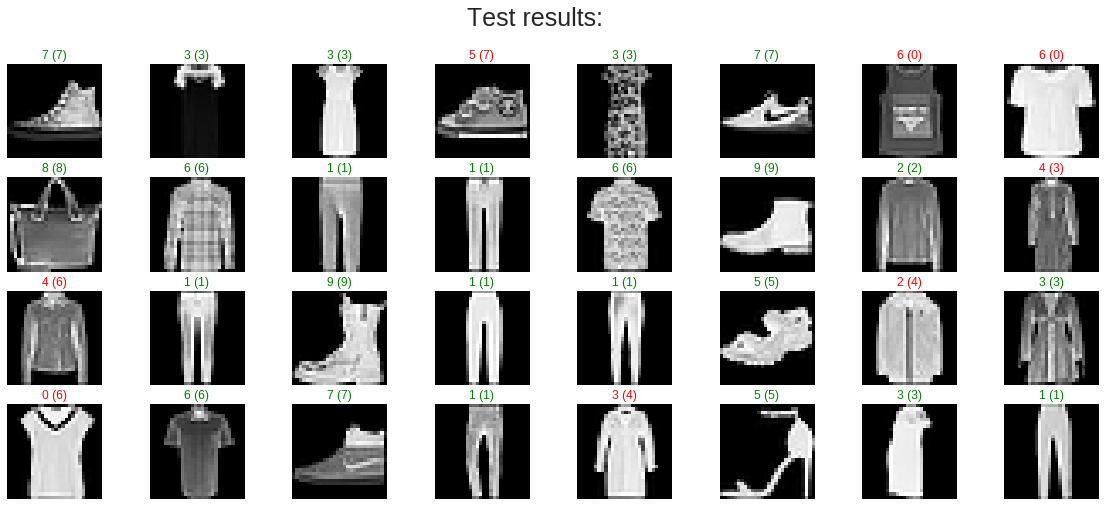

In [0]:
## Load the best model:

## Get test predictions:

## Visualise some results:
visualize_model_predictions(model, x_test, y_test, 'Test')


## 2.2 Let's make our model Deeper! 
Add two extra hidden layers to start with.
Explore the effects of adding more depth/width to your network, what happens to the number of trainable parameters?
What about training speed, test-accuracy, ... Notice that there usually is a clear tradeoff between training-time and model performance.

In [0]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))

model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Take a look at the model summary
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_37 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_38 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_39 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_40 (Dense)             (None, 10)                650       
Total params: 142,410
Trainable params: 142,410
Non-trainable params: 0
_________________________________________________________________


# Adding callbacks
Because we just made our model a lot deeper, it will have to train longer in order to use its full potential!
But obviously, we don't want to keep training too long or we'll overfit.
To get more info during training we'll add two extra callbacks to the model.fit() method that:
1. Stop the model training loop if the validation loss keeps dropping consistently (eg 10 times in a row) (This is a default callback, available in Keras)
2. Periodically visualise the validation error while training (This is a custom callback function you will have to create yourself)

You can find more documentation here: https://keras.io/callbacks/ (For the custom callback, scroll down to "Create a callback" section)

In [0]:
class plot_train_progress(keras.callbacks.Callback):
    def __init__(self, plot_every_n_epochs = 5, plot_fraction = 0.9):
        self.plot_frequency = plot_every_n_epochs
        self.plot_fraction = plot_fraction #Plot only the most recent values
        
    def on_train_begin(self, logs={}):
        self.train_losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.plot_frequency == 0:
            nr_values_to_plot = int(self.plot_fraction * len(self.train_losses))
            if nr_values_to_plot > 1:
                t = list(range(nr_values_to_plot))
                plt.plot(t, self.train_losses[-nr_values_to_plot:], 'b')
                plt.plot(t, self.val_losses[-nr_values_to_plot:], 'g')
                plt.xlabel('# Batches')
                plt.ylabel('Validation Loss')
                #plt.savefig('train_progress.jpg')
                plt.show()

    def on_batch_end(self, batch, logs={}):
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
earlyStopping= keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min')
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 0, save_best_only=True)
callbacks_list = [checkpointer, plot_train_progress(5, .9), earlyStopping]





Train on 54000 samples, validate on 6000 samples
Epoch 1/10
53760/54000 [============================>.] - ETA: 0s - loss: 0.5760 - acc: 0.7963

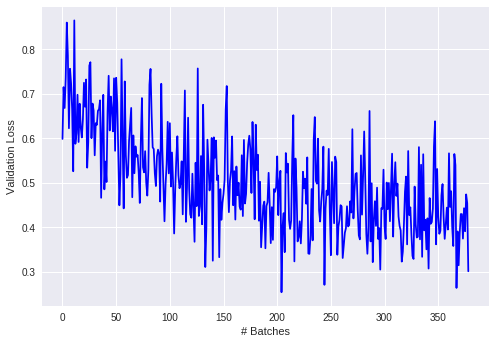

54000/54000 [==============================] - 7s 136us/step - loss: 0.5751 - acc: 0.7964 - val_loss: 0.4789 - val_acc: 0.8237
Epoch 2/10
54000/54000 [==============================] - 4s 79us/step - loss: 0.3832 - acc: 0.8599 - val_loss: 0.3792 - val_acc: 0.8602
Epoch 3/10
54000/54000 [==============================] - 4s 79us/step - loss: 0.3386 - acc: 0.8754 - val_loss: 0.3459 - val_acc: 0.8708
Epoch 4/10
54000/54000 [==============================] - 4s 80us/step - loss: 0.3169 - acc: 0.8834 - val_loss: 0.3363 - val_acc: 0.8757
Epoch 5/10
54000/54000 [==============================] - 5s 88us/step - loss: 0.2979 - acc: 0.8889 - val_loss: 0.3670 - val_acc: 0.8642
Epoch 6/10
53504/54000 [============================>.] - ETA: 0s - loss: 0.2848 - acc: 0.8943

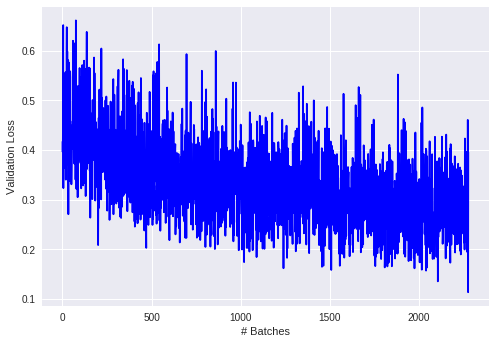

54000/54000 [==============================] - 5s 90us/step - loss: 0.2849 - acc: 0.8943 - val_loss: 0.3425 - val_acc: 0.8725
Epoch 7/10
54000/54000 [==============================] - 4s 82us/step - loss: 0.2664 - acc: 0.9002 - val_loss: 0.3352 - val_acc: 0.8798
Epoch 8/10
54000/54000 [==============================] - 4s 81us/step - loss: 0.2577 - acc: 0.9047 - val_loss: 0.3193 - val_acc: 0.8795
Epoch 9/10
54000/54000 [==============================] - 4s 82us/step - loss: 0.2506 - acc: 0.9052 - val_loss: 0.3132 - val_acc: 0.8847
Epoch 10/10
54000/54000 [==============================] - 4s 81us/step - loss: 0.2383 - acc: 0.9095 - val_loss: 0.3212 - val_acc: 0.8890


In [0]:
#Fit the model:
model.fit(x_train,
         y_train,
         batch_size=128,
         epochs=10,
         validation_data=(x_valid, y_valid),
         callbacks=callbacks_list)


## Evaluate the model

In [0]:
model.load_weights('model.weights.best.hdf5')
score = model.evaluate(x_test, y_test, verbose=0)

print('Test accuracy: %.2f%%' %(100*score[1]))

Test accuracy: 88.56%


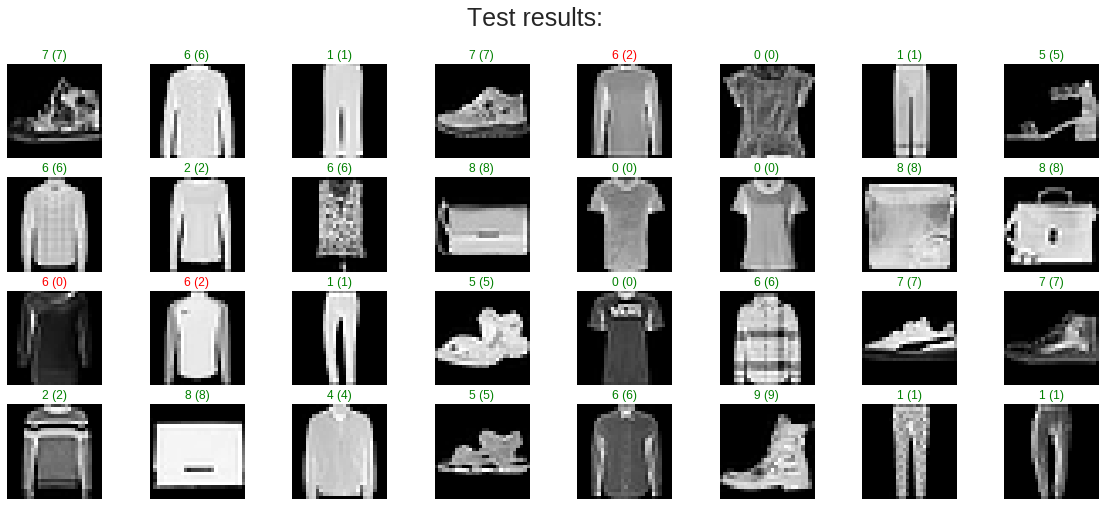

In [0]:
visualize_model_predictions(model, x_test, y_test, 'Test')


**Extra:** To experiment and get some intuition as to why making the network deeper makes it easier to fit the data, you can experiment with this amazing in-browser tool: https://playground.tensorflow.org/

## 2.2 Convolutions 
### Lets add in some of the big guns in Computer Vision: Convolutions!

Notice that up until now, we've always started our network with a Flatten() operation that basically throws away all the spatial dependency information in our image. Time to change that!

Chain two Conv2D layers in the beginning of the network (remove the Flatten operation) and follow each one with a MaxPooling2D layer to downscale the resolution of the hidden representations. Finally add some normal FC layers to map the convolutional features to the output classes. (You will need to re-add a Flatten() operation for this).
Play around with different architectures and keep track of the following variables:
- Total number of trainable parameters in the network
- Network depth (how many non-linear layers do I have that transform the data from pixel-space to label-space?)
- Training time per epoch
- Final accuracy after training for N epochs

You can find the documentation for the Conv2D layers here: https://keras.io/layers/convolutional/

**Extra question:** What does the MaxPooling2D operation do exactly? Do we lose any information in this step? What is good/bad about that?

In [0]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(28,28,1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Take a look at the model summary
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 128)               102528    
_________________________________________________________________
dense_42 (Dense)             (None, 128)               16512     
__________

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
53888/54000 [============================>.] - ETA: 0s - loss: 0.6546 - acc: 0.7588

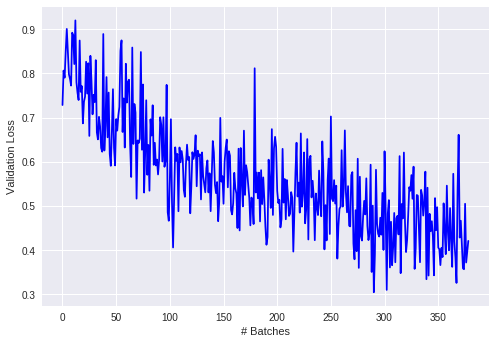

54000/54000 [==============================] - 9s 163us/step - loss: 0.6541 - acc: 0.7589 - val_loss: 0.4247 - val_acc: 0.8375
Epoch 2/10
54000/54000 [==============================] - 6s 103us/step - loss: 0.3883 - acc: 0.8588 - val_loss: 0.3501 - val_acc: 0.8730
Epoch 3/10
54000/54000 [==============================] - 6s 104us/step - loss: 0.3280 - acc: 0.8811 - val_loss: 0.3249 - val_acc: 0.8800
Epoch 4/10
54000/54000 [==============================] - 5s 102us/step - loss: 0.2952 - acc: 0.8924 - val_loss: 0.2939 - val_acc: 0.8927
Epoch 5/10
54000/54000 [==============================] - 6s 107us/step - loss: 0.2684 - acc: 0.9009 - val_loss: 0.2845 - val_acc: 0.8937
Epoch 6/10
53888/54000 [============================>.] - ETA: 0s - loss: 0.2525 - acc: 0.9060

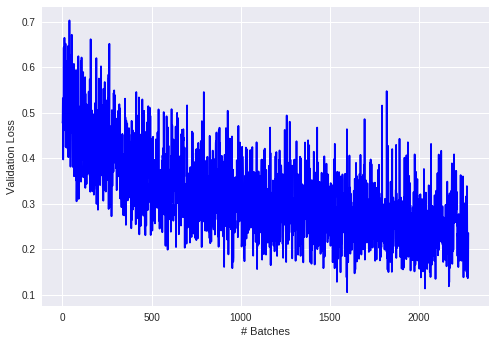

54000/54000 [==============================] - 6s 108us/step - loss: 0.2525 - acc: 0.9060 - val_loss: 0.2810 - val_acc: 0.8953
Epoch 7/10
54000/54000 [==============================] - 6s 106us/step - loss: 0.2369 - acc: 0.9119 - val_loss: 0.2645 - val_acc: 0.9025
Epoch 8/10
54000/54000 [==============================] - 5s 100us/step - loss: 0.2191 - acc: 0.9192 - val_loss: 0.2622 - val_acc: 0.9060
Epoch 9/10
54000/54000 [==============================] - 5s 99us/step - loss: 0.2071 - acc: 0.9231 - val_loss: 0.2564 - val_acc: 0.9102
Epoch 10/10
54000/54000 [==============================] - 5s 99us/step - loss: 0.1964 - acc: 0.9266 - val_loss: 0.2451 - val_acc: 0.9118


In [0]:
# Train the model:
earlyStopping= keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 0, save_best_only=True)
callbacks_list = [checkpointer, plot_train_progress(5, .9), earlyStopping]

model.fit(x_train,
         y_train,
         batch_size=128,
         epochs=10,
         validation_data=(x_valid, y_valid),
         callbacks=callbacks_list)



## Evaluate model

In [0]:
model.load_weights('model.weights.best.hdf5')
score = model.evaluate(x_test, y_test, verbose=0)

print('Test accuracy: %.2f%%' %(100*score[1]))

Test accuracy: 90.80%


**Extra**:
Run the visualize_model_predictions() function both on some examples from the training data and the test data, do you notice any differences? Is there an overall difference between the accuracy on the Train-set vs the Test-set? What is going on?

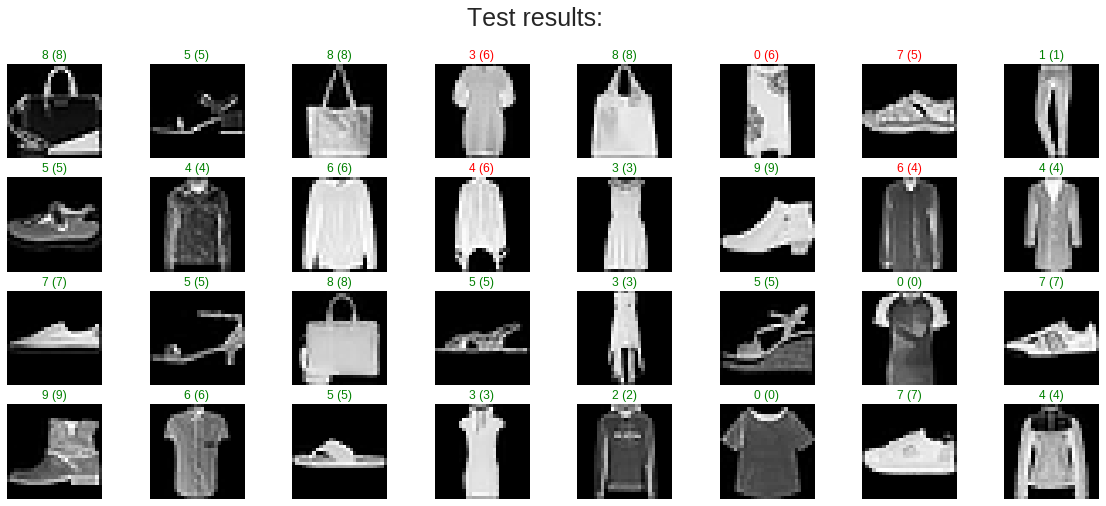

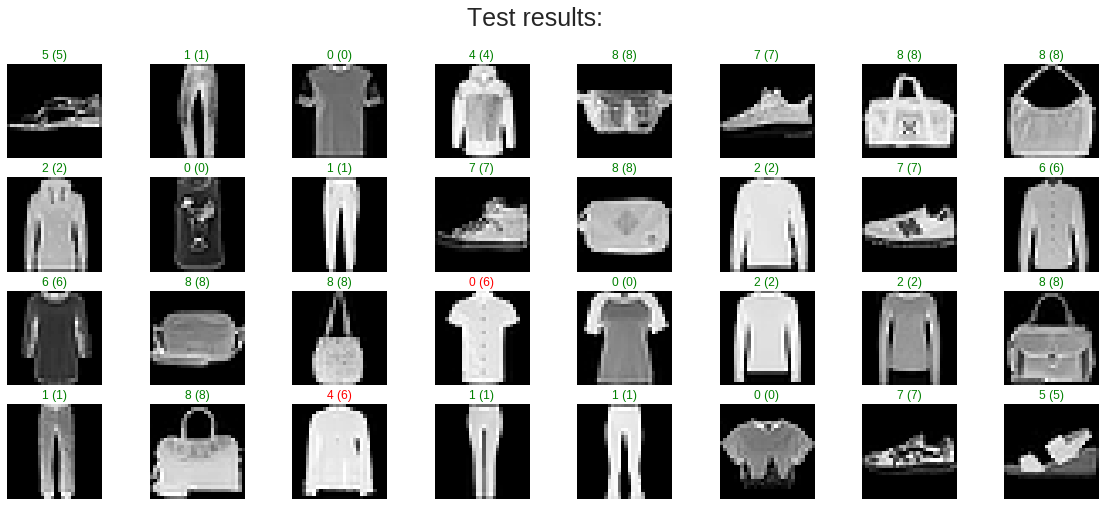

In [0]:
visualize_model_predictions(model, x_test, y_test,'Test')
visualize_model_predictions(model, x_train, y_train,'Test')

#Compute & compare train and test accuracies:


# 3 Regularization

Our model currently has a lot of degrees of freedom (it has a LOT of trainable parameters and can therefore fit almost any function if we just keep training for long enough). This means our network is also prone to overfitting. 

In this section, let's add dropout layers between the main parts of our network to avoid overfitting.
What is a good dropout rate?

**Extra:** To get an idea of the degree to which these networks can overfit take a look at this amazing paper which shows that a large enough CNN can basically memorize a very large, random dataset: https://arxiv.org/abs/1611.03530

**Extra:** Also try to add an L2 Regularization penalty to every layer in your network. What is a good setting of the multiplier constant? (see https://keras.io/regularizers/)

In [0]:
model = tf.keras.Sequential()

# Define the model:
# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(28,28,1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 800)               0         
__________

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
53632/54000 [============================>.] - ETA: 0s - loss: 0.7324 - acc: 0.7225

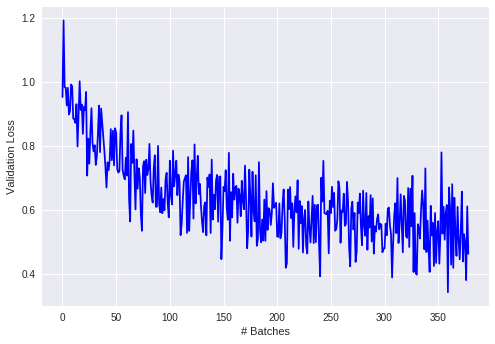

54000/54000 [==============================] - 9s 170us/step - loss: 0.7308 - acc: 0.7233 - val_loss: 0.4793 - val_acc: 0.8200
Epoch 2/10
54000/54000 [==============================] - 6s 108us/step - loss: 0.4689 - acc: 0.8268 - val_loss: 0.3887 - val_acc: 0.8575
Epoch 3/10
54000/54000 [==============================] - 6s 107us/step - loss: 0.3999 - acc: 0.8526 - val_loss: 0.3512 - val_acc: 0.8753
Epoch 4/10
54000/54000 [==============================] - 6s 109us/step - loss: 0.3615 - acc: 0.8662 - val_loss: 0.3217 - val_acc: 0.8845
Epoch 5/10
54000/54000 [==============================] - 6s 106us/step - loss: 0.3374 - acc: 0.8755 - val_loss: 0.3019 - val_acc: 0.8895
Epoch 6/10
53632/54000 [============================>.] - ETA: 0s - loss: 0.3182 - acc: 0.8830

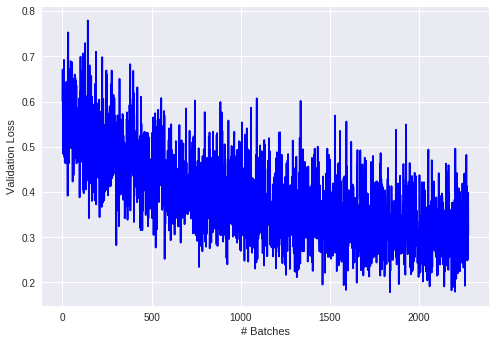

54000/54000 [==============================] - 6s 112us/step - loss: 0.3182 - acc: 0.8829 - val_loss: 0.2819 - val_acc: 0.8998
Epoch 7/10
54000/54000 [==============================] - 6s 108us/step - loss: 0.3030 - acc: 0.8874 - val_loss: 0.2698 - val_acc: 0.9000
Epoch 8/10
54000/54000 [==============================] - 6s 107us/step - loss: 0.2911 - acc: 0.8923 - val_loss: 0.2815 - val_acc: 0.8942
Epoch 9/10
54000/54000 [==============================] - 6s 108us/step - loss: 0.2772 - acc: 0.8956 - val_loss: 0.2619 - val_acc: 0.9038
Epoch 10/10
54000/54000 [==============================] - 6s 109us/step - loss: 0.2694 - acc: 0.9006 - val_loss: 0.2522 - val_acc: 0.9053


In [0]:
earlyStopping= keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 0, save_best_only=True)
callbacks_list = [checkpointer, plot_train_progress(5, .9), earlyStopping]

model.fit(x_train,
         y_train,
         batch_size=128,
         epochs=10,
         validation_data=(x_valid, y_valid),
         callbacks=callbacks_list)

## Evaluate model:

In [0]:
model.load_weights('model.weights.best.hdf5')

test_score = model.evaluate(x_test, y_test, verbose=0)
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train accuracy: %.2f%% || Test accuracy: %.2f%%' %(100*train_score[1], 100*test_score[1]))

Train accuracy: 92.11% || Test accuracy: 90.06%
